In [1]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [2]:
imagePaths = []
for dirname, _, filenames in os.walk('COVID-19 Radiography Database'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [3]:
imgSize = 225


X = []
Y = []
hmap = {'COVID':'COVID','NORMAL':'NORMAL','Viral Pneumonia':'Viral Pneumonia'}
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgSize, imgSize))

    X.append(image)
    Y.append(hmap[label])

100%|██████████████████████████████████████████████████████████████████████████████| 3886/3886 [01:21<00:00, 47.88it/s]


In [4]:
print('Covid-19:',Y.count('COVID'))
print('Normal:',Y.count('NORMAL'))
print('Viral Pneumonia: ',Y.count('Viral Pneumonia'))

Covid-19: 1200
Normal: 1341
Viral Pneumonia:  1345


In [5]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y)

In [6]:
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.40, stratify=Y, random_state=None)

In [7]:
trainX = np.array(trainX).astype('float16')/255

testX = np.array(testX).astype('float16')/255

In [8]:
trainAug = ImageDataGenerator()
trainAug

In [9]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('VGG-16.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model.save('VGG-16.h5')

In [10]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(imgSize, imgSize, 3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 225, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 225, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 225, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

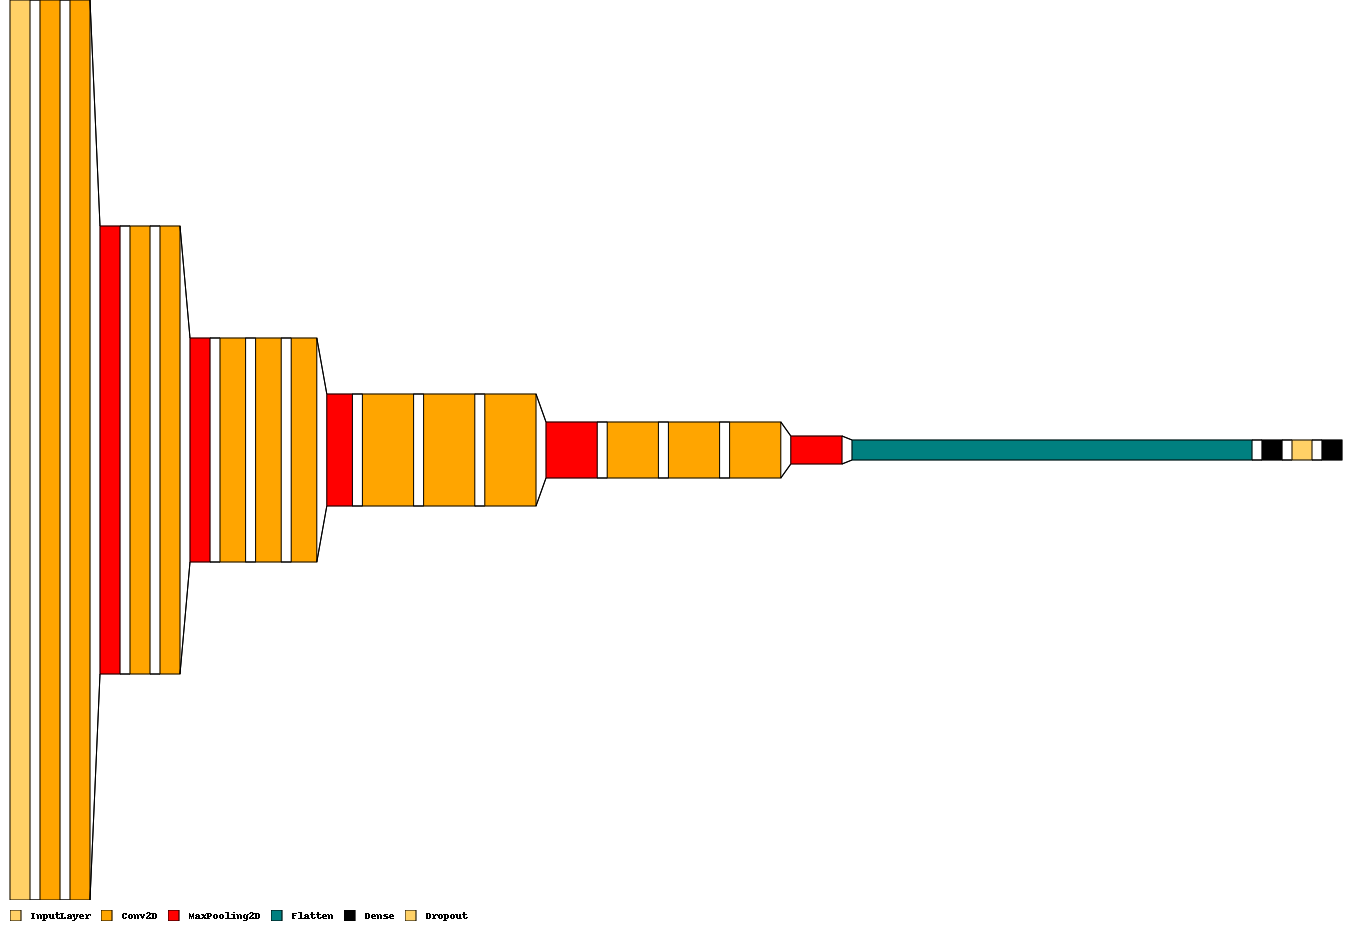

In [12]:
import visualkeras
from collections import defaultdict
from tensorflow.keras import layers
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'orange'
color_map[layers.MaxPooling2D]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'black'
color_map[layers.Flatten]['fill'] = 'teal'
visualkeras.layered_view(model, legend=True,color_map=color_map,draw_volume=False) 

In [17]:
EPOCHS = 20
BS = 32
opt = Adam()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),],
    epochs=EPOCHS)

Epoch 1/20
72/72 [==============================] - 105s 1s/step - loss: 0.5099 - accuracy: 0.8060 - val_loss: 0.2525 - val_accuracy: 0.9151
Epoch 2/20
72/72 [==============================] - 103s 1s/step - loss: 0.2607 - accuracy: 0.9139 - val_loss: 0.2123 - val_accuracy: 0.9241
Epoch 3/20
72/72 [==============================] - 103s 1s/step - loss: 0.2228 - accuracy: 0.9261 - val_loss: 0.1891 - val_accuracy: 0.9344
Epoch 4/20
72/72 [==============================] - 103s 1s/step - loss: 0.2008 - accuracy: 0.9426 - val_loss: 0.1738 - val_accuracy: 0.9415
Epoch 5/20
72/72 [==============================] - 124s 2s/step - loss: 0.1727 - accuracy: 0.9426 - val_loss: 0.1775 - val_accuracy: 0.9415
Epoch 6/20
72/72 [==============================] - 118s 2s/step - loss: 0.1723 - accuracy: 0.9404 - val_loss: 0.1667 - val_accuracy: 0.9389
Epoch 7/20
72/72 [==============================] - 103s 1s/step - loss: 0.1652 - accuracy: 0.9456 - val_loss: 0.1642 - val_accuracy: 0.9428
Epoch 8/20
72

In [18]:
print(len(Y))

3886


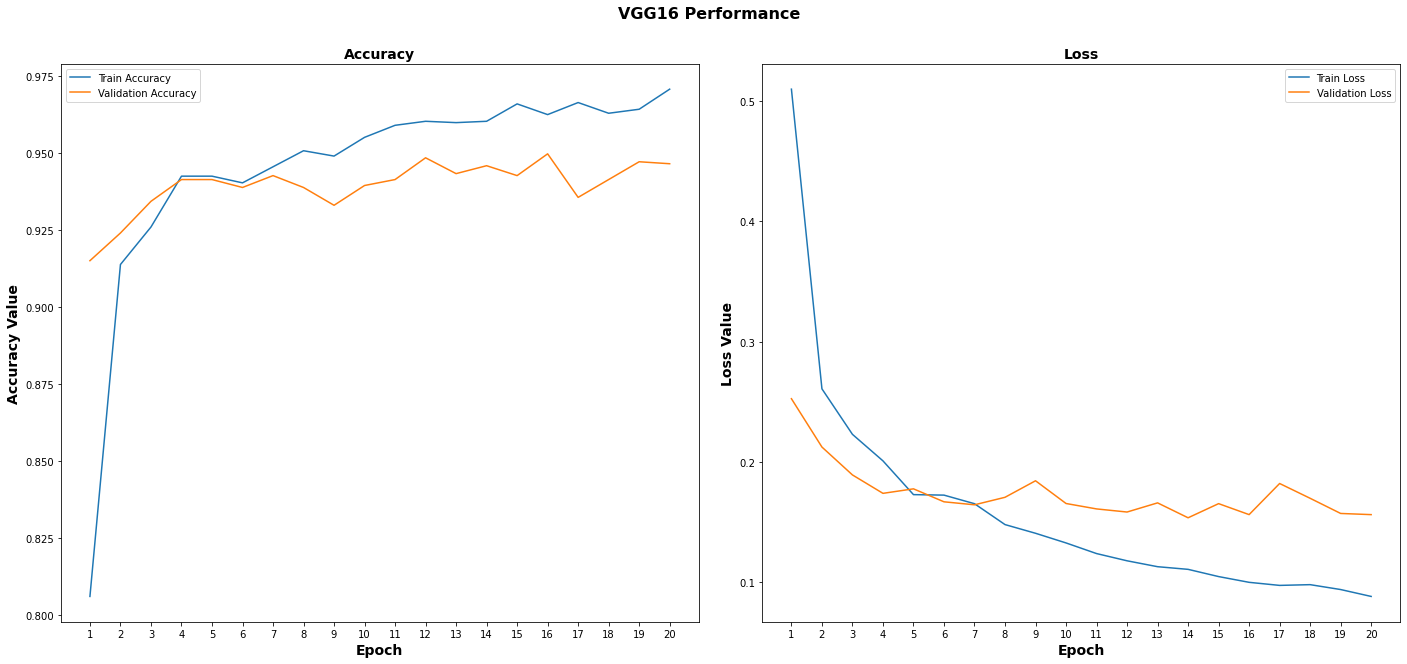

In [22]:
from sklearn.metrics import accuracy_score
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
t = f.suptitle('VGG16 Performance', fontsize=16,fontweight='bold')
f.subplots_adjust(top=0.9, wspace=0.1)

max_epoch = len(H.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, H.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, H.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax1.set_title('Accuracy', fontsize=14,fontweight='bold')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, H.history['loss'], label='Train Loss')
ax2.plot(epoch_list, H.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax2.set_title('Loss',fontsize=14,fontweight='bold')
l2 = ax2.legend(loc="best")

In [20]:
model= load_model('model.h5')

predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

                 precision    recall  f1-score   support

          COVID    0.97669   0.96042   0.96849       480
         NORMAL    0.95283   0.94041   0.94658       537
Viral Pneumonia    0.92405   0.94981   0.93676       538

       accuracy                        0.94984      1555
      macro avg    0.95119   0.95021   0.95061      1555
   weighted avg    0.95024   0.94984   0.94994      1555



<function matplotlib.pyplot.show(close=None, block=None)>

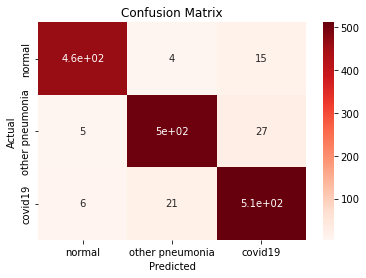

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.metrics as metrics
import pandas as pd
import seaborn as sns
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
pred = model.predict(testX)
pred=np.argmax(pred,axis=1)
# pred = model.predict_classes(X_test)
Y_TEST = np.argmax(testY, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'other pneumonia', 'covid19']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Reds')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show